In [1]:
%matplotlib inline
from copy import deepcopy as copy
import json
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.sparse import csc_matrix

from aux import Generic
from disp import set_font_size, set_n_x_ticks, set_n_y_ticks, set_color
from ntwk import LIFNtwkG, join_w

cc = np.concatenate


LOAD_PRFX = 'PARAM_SWEEP_RESULTS'
SAVE_PRFX = 'PARAM_SWEEP_RESULTS_EXT'

# model
M_PARAMS = {
    # Exc. PC membrane
    'C_M_PC': 0.5e-9, 'G_L_PC': 10e-9, 'E_L_PC': -0.05, 'V_TH_PC': -0.036, 'V_R_PC': -0.05, 'T_R_PC': 0.008,
    
    # Exc. PC architecture
    'N_PC': 1500,
    'W_PC_PC': .026e-6, 'L_PC_PC': 0.053, 'W_MIN_PC_PC': 0.001e-6,
    
    # Inh. membrane
    'C_M_INH': .05e-9, 'G_L_INH': 10e-9, 'E_L_INH': -0.06, 'V_TH_INH': -0.05, 'V_R_INH': -0.06, 'T_R_INH': 0.002,
    
    # Inh. architecture
    'N_INH': 150,
    'W_INH_PC': 0.005e-7, 'W_PC_INH': 0.0002e-6,
    
    # synaptic reversal potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002, 
}

# simulation
S_PARAMS = {
    "RNG_SEED": None,
    "DT": 0.0005, "BOX_H": .5, "BOX_W": 4, "X_TRG": 1, "Y_TRG": -0.75,
    
    'TRG': [
        {'T': 0.15, 'A': 0.01e-6, 'R': 0.15, 'D': 0.002, 'X': -2, 'Y': 0},
    ],
    
    'D_SMLN': 1,
}

In [2]:
def apx_lattice(lb, ub, n, randomize):
    """
    Arrange n points on an apx. lattice within a rectangle.
    (Apx. b/c rectangle dims may not evenly divide n.)
    """
    lb_x, lb_y = lb
    ub_x, ub_y = ub

    r_x = ub_x - lb_x
    r_y = ub_y - lb_y

    # get apx factors of n
    n_x = np.sqrt((r_x/r_y) * n)
    n_y = n/n_x

    # get # pts per row
    n_rows = int(np.round(n_y))
    n_pts = [len(row) for row in np.array_split(np.arange(n), n_rows)]

    # evenly distribute n_pts so that largest rows are not clumped at top
    if len(set(n_pts)) > 1:
        
        ## split into groups of same n_pts
        gp_0, gp_1 = [[ii for ii in n_pts if ii == i] for i in set(n_pts)]

        if len(gp_1) > len(gp_0):
            gp_0, gp_1 = gp_1, gp_0

        ## assign float "t" to each n_pt
        n_0 = len(gp_0)
        n_1 = len(gp_1)

        ts_0 = [k * (n - 1) / (n_0 - 1) for k in range(n_0)]
        ts_1 = [k * (n - 1) / (n_1 + 1) for k in range(1, n_1 + 1)]

        ts = cc([ts_0, ts_1])

        ## sort n_pts according to ts
        n_pts = cc([gp_0, gp_1])[np.argsort(ts)]
    
    # assign (x, y) positions
    ys_row = np.linspace(lb_y, ub_y, n_rows+2)[1:-1]

    xs = []
    ys = []

    ## add group of positions for each row
    for y_row, n_pts_ in zip(ys_row, n_pts):

        xs_ = list(np.linspace(lb_x, ub_x, n_pts_ + 2)[1:-1])
        ys_ = list(np.repeat(y_row, len(xs_)))

        xs.extend(xs_)
        ys.extend(ys_)
        
    xs = np.array(xs)
    ys = np.array(ys)
    
    if randomize:
        shuffle = np.random.permutation(n)
        
        xs = xs[shuffle]
        ys = ys[shuffle]

    return xs, ys


def _w_pc_pc_vs_d(d, p):
    """Return distance-dependent portion of w_pc_pc computation."""
    assert np.all(d >= 0)
    
    # decrease weights as squared exp of dist
    w = p['W_PC_PC'] * np.exp(-d**2/(2*p['L_PC_PC']**2))
    
    # set all weights below min weight th to 0
    w[w < p['W_MIN_PC_PC']] = 0
    
    return w


def make_w_pc_pc(pfxs, pfys, p):
    """Make PC-PC weight mat w/ weight increasing w/ proxim."""
    n_pc = p['N_PC']
    
    # build distance matrix
    dx = np.tile(pfxs[None, :], (n_pc, 1)) - np.tile(pfxs[:, None], (1, n_pc))
    dy = np.tile(pfys[None, :], (n_pc, 1)) - np.tile(pfys[:, None], (1, n_pc))
    d = np.sqrt(dx**2 + dy**2)
    
    # build weight matrix
    return _w_pc_pc_vs_d(d, p)
    

def make_w_inh_pc(pfxs_inh, pfys_inh, pfxs_pc, pfys_pc, p):
    """
    Make proximally biased PC->INH weight matrix.
    """
    n_inh = p['N_INH']
    n_pc = p['N_PC']
    
    # build weight matrix
    w_inh_pc = p['W_INH_PC'] * (np.random.rand(n_inh, n_pc) < 0.5).astype(float)
    return w_inh_pc
    
    
def make_w_pc_inh(pfxs_pc, pfys_pc, pfxs_inh, pfys_inh, p):
    """
    Make center-surround structured INH->PC weight matrix.
    """
    n_pc = p['N_PC']
    n_inh = p['N_INH']
    
    # build weight matrix
    w_pc_inh = p['W_PC_INH'] * (np.random.rand(n_pc, n_inh) < 0.5).astype(float)
    return w_pc_inh

In [3]:
def smln_run(p, s_params):
    """
    Run smln and return rslt.
    
    :param p: dict of model params
    :param s_params: dict of smln params
    """
    t = np.arange(0, s_params['D_SMLN'], s_params['DT'])
    
    ## build ntwk
    ntwk = build_ntwk(p, s_params)
   
    i_ext = build_stim(t, ntwk, p, s_params)
    
    # run smln
    clamp = Generic(
        v={0: cc([np.repeat(p['E_L_PC'], p['N_PC']), np.repeat(p['E_L_INH'], p['N_INH'])])},
        spk={})
    rslt = ntwk.run(i_ext=i_ext, clamp=clamp, dt=s_params['DT'])
    
    # consolidate smln rslt
    rslt.ntwk = ntwk
    rslt.trg = s_params['TRG']
    
    rslt.p = p
    rslt.s_params = s_params
    
    return rslt


def build_ntwk(p, s_params):
    """
    Construct a network object from the model and
    simulation params.
    """
    np.random.seed(s_params['RNG_SEED'])
    
    # set membrane properties
    n = p['N_PC'] + p['N_INH']
    
    c_m = cc(
        [np.repeat(p['C_M_PC'], p['N_PC']), np.repeat(p['C_M_INH'], p['N_INH'])])
    g_l = cc(
        [np.repeat(p['G_L_PC'], p['N_PC']), np.repeat(p['G_L_INH'], p['N_INH'])])
    e_l = cc(
        [np.repeat(p['E_L_PC'], p['N_PC']), np.repeat(p['E_L_INH'], p['N_INH'])])
    v_th = cc(
        [np.repeat(p['V_TH_PC'], p['N_PC']), np.repeat(p['V_TH_INH'], p['N_INH'])])
    v_r = cc(
        [np.repeat(p['V_R_PC'], p['N_PC']), np.repeat(p['V_R_INH'], p['N_INH'])])
    t_rp = cc(
        [np.repeat(p['T_R_PC'], p['N_PC']), np.repeat(p['T_R_INH'], p['N_INH'])])
    
    # set latent nrn positions
    lb = [-s_params['BOX_W']/2, -s_params['BOX_H']/2]
    ub = [s_params['BOX_W']/2, s_params['BOX_H']/2]
    
    # sample evenly spaced place fields
    ## E cells
    pfxs_e, pfys_e = apx_lattice(lb, ub, p['N_PC'], randomize=True)
    ## I cells
    pfxs_i, pfys_i = apx_lattice(lb, ub, p['N_INH'], randomize=True)
    
    ## join E & I place fields
    pfxs = cc([pfxs_e, pfxs_i])
    pfys = cc([pfys_e, pfys_i])
       
    w_u = {'E': np.zeros((p['N_PC'] + p['N_INH'], 0))}
    
    # make rcr ws
    w_pc_pc = make_w_pc_pc(pfxs[:p['N_PC']], pfys[:p['N_PC']], p)

    w_inh_pc = make_w_inh_pc(
        pfxs_inh=pfxs[-p['N_INH']:],
        pfys_inh=pfys[-p['N_INH']:],
        pfxs_pc=pfxs[:p['N_PC']],
        pfys_pc=pfys[:p['N_PC']],
        p=p)
    
    w_pc_inh = make_w_pc_inh(
        pfxs_pc=pfxs[:p['N_PC']],
        pfys_pc=pfys[:p['N_PC']],
        pfxs_inh=pfxs[-p['N_INH']:],
        pfys_inh=pfys[-p['N_INH']:],
        p=p)
    
    w_r_temp = {
        'E': {
            ('PC', 'PC'): w_pc_pc,
            ('INH', 'PC'): w_inh_pc,
        },
        'I': {
            ('PC', 'INH'): w_pc_inh,
        },
    }
    targs_rcr = cc([np.repeat('PC', p['N_PC']), np.repeat('INH', p['N_INH'])])
    
    w_r = join_w(targs_rcr, targs_rcr, w_r_temp)
    
    # make ntwk
    ntwk = LIFNtwkG(
        c_m=c_m,
        g_l=g_l,
        e_l=e_l,
        v_th=v_th,
        v_r=v_r,
        t_r=t_rp,
        e_s={'E': p['E_E'], 'I': p['E_I']},
        t_s={'E': p['T_E'], 'I': p['T_I']},
        w_r=w_r,
        w_u=w_u)
    
    ntwk.pfxs = pfxs
    ntwk.pfys = pfys
    
    ntwk.types_rcr = targs_rcr
    
    ntwk.n_pc = p['N_PC']
    ntwk.n_inh = p['N_INH']
    ntwk.n_rcr = p['N_PC'] + p['N_INH']
    
    ntwk.types_rcr_slc = {
        'PC': slice(0, p['N_PC']),
        'INH': slice(p['N_PC'], p['N_PC'] + p['N_INH'])
    }
    
    return ntwk

       
def build_stim(t, ntwk, p, s_params):
    """
    Put together upstream spk and external current inputs
    according to stimulation params and schedule.
    """
    # initialize external current array
    i_ext = np.zeros((len(t), p['N_PC'] + p['N_INH']))
    
    # add replay trigger
    i_ext += i_ext_trg(t, ntwk, p, s_params)
    
    return i_ext


def i_ext_trg(t, ntwk, p, s_params):
    """
    Add replay trigger to external current stim.
    """
    i_ext = np.zeros((len(t), p['N_PC'] + p['N_INH']))
    
    # get mask over cells to trigger to induce replay
    for trg in s_params['TRG']:
        
        ## compute distances to trigger center
        trg_mask = get_trg_mask_pc(ntwk, p, trg)

        ## get time mask
        t_mask = (trg['T'] <= t) \
            & (t < (trg['T'] + trg['D']))

        ## add in external trigger
        i_ext[np.outer(t_mask, trg_mask)] = trg['A']

    return i_ext


def get_trg_mask_pc(ntwk, p, trg):
    """Get spatial mask for replay trigger."""
    dx = ntwk.pfxs - trg['X']
    dy = ntwk.pfys - trg['Y']
    d = np.sqrt(dx**2 + dy**2)
    
    ## get mask
    trg_mask = (d < trg['R']) & (ntwk.types_rcr == 'PC')
    
    return trg_mask

In [4]:
def get_idxs_nearest(xys, pfxs, pfys, nearest, colors):
    """
    Get ordered idxs of place fields nearest to a
    sequence of (x, y) points.
    """
    idxs = []
    c_dict_0 = {}
    c_dict_1 = []
    
    for xy, color in zip(xys, colors):
        # get dists of all PFs to (x, y)
        dx = pfxs - xy[0]
        dy = pfys - xy[1]
        d = np.sqrt(dx**2 + dy**2)
        
        # add idxs of closest neurons to list
        pcs = list(d.argsort()[:nearest])
        idxs.extend(pcs)
        
        for pc in pcs:
            c_dict_0[pc] = color
            
        c_dict_1.extend(len(pcs)*[color])
        
    return idxs, c_dict_0, np.array(c_dict_1)


def plot_spike_seq(rslt, epoch, cmap='gist_rainbow', sct_sz=25):
    """Plot spike count and order during specified epoch."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)

    ## detection wdw
    start = epoch[0]
    end = epoch[1]

    t_mask = (start <= rslt.t) & (rslt.t < end)

    ## PC mask and PFs
    pc_mask = rslt.ntwk.types_rcr == 'PC'

    pfxs_pc = rslt.ntwk.pfxs[pc_mask]
    pfys_pc = rslt.ntwk.pfys[pc_mask]

    ## PC spk cts within detection window
    spks_wdw_pc = rslt.spks[t_mask][:, pc_mask]
    spk_ct_wdw_pc = spks_wdw_pc.sum(0)

    ## discrete colormap for showing spk cts
    c_map_tmp = plt.cm.jet
    c_map_list = [c_map_tmp(i) for i in range(c_map_tmp.N)]
    c_map_list[0] = (0., 0., 0., 1.)
    c_map = c_map_tmp.from_list('spk_ct', c_map_list, c_map_tmp.N)

    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, c_map.N)

    # PC spiking order
    if np.any(spk_ct_wdw_pc):

        ## black bkgd for all PCs
        ax.scatter(pfxs_pc, pfys_pc, c='k', s=25, zorder=-1)

        ## color PCs according to timing of first spike
        spk_mask = spk_ct_wdw_pc > 0
        spk_order = np.argmax(spks_wdw_pc[:, spk_mask], 0)
        spk_order = np.argsort(spk_order).argsort()
        
        v_min = spk_order.min()
        v_max = spk_order.max()

        im_1 = ax.scatter(
            pfxs_pc[spk_mask], pfys_pc[spk_mask], c=spk_order, s=sct_sz,
            vmin=v_min, vmax=v_max, cmap=cmap, zorder=0)

        divider_1 = make_axes_locatable(ax)
        c_ax_1 = divider_1.append_axes('right', size='5%', pad=0.05)

        cb_1 = fig.colorbar(im_1, cax=c_ax_1, ticks=[v_min, v_max])
        cb_1.set_ticklabels(['first', 'last'])

        ax.set_aspect('equal')
        
        set_n_x_ticks(ax, 5, -rslt.s_params['BOX_W']/2, rslt.s_params['BOX_W']/2)
        set_n_y_ticks(ax, 5, -rslt.s_params['BOX_H']/2, rslt.s_params['BOX_H']/2)
        
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)', labelpad=-12)
        c_ax_1.set_ylabel('Spike order', labelpad=-25)
        ax.set_title('Spikes from {} to {} s.'.format(*epoch))
        for ax_ in [ax, cb_1.ax]:
            set_font_size(ax_, 20)
    else:
        ax.set_title('No PC spks')
        set_font_size(ax, 20)
    ax.set_facecolor((.7, .7, .7))

    return fig, ax


def plot_raster_with_pc_inh(
        rslt, xys, colors, cmap, nearest, epoch, trg_plt, y_lim, y_ticks,
        smoothness=1, n_t_ticks=None, fig_size=(15, 9), title=None):
    """
    Make raster plots of PCs specified by place fields, along with full PC/INH rasters/rate traces.
    
    :param xys: list of (x, y) locs to plot spks from nearby cells for
    :param nearest: # of cells per (x, y)
    :param epoch: 'replay', 'wdw', 'trj', or 'full', specifying which epoch
        to make raster for (replay, detection window, trajectory, or full smln)
    """
    fig, axs = plt.subplots(3, 1, figsize=fig_size, tight_layout=True)
    
    # get ordered idxs of PCs to plot
    ## get pfs
    pc_mask = rslt.ntwk.types_rcr == 'PC'
    pfxs = rslt.ntwk.pfxs[pc_mask]
    pfys = rslt.ntwk.pfys[pc_mask]
    
    ## loop through (x, y) pairs and add idxs of nearest PCs
    ### pc_c_dict_0 uses original pc idxs, pc_c_dict_1 uses simplified pc idxs
    pc_idxs, pc_c_dict_0, pc_c_dict_1 = get_idxs_nearest(xys, pfxs, pfys, nearest, colors) 
    
    # get all spks for selected PCs
    spks_pc_chosen = rslt.spks[:, pc_idxs]
    
    # get desired time window
    if epoch == 'replay':
        start = 0
        end = rslt.schedule['D_SMLN']
    elif isinstance(epoch, tuple):
        start = epoch[0]
        end = epoch[1]
    
    t_mask = (start <= rslt.t) & (rslt.t < end)
    t_start = rslt.t[t_mask][0]
    
    spk_t_idxs, pcs = spks_pc_chosen[t_mask].nonzero()
    spk_ts = spk_t_idxs * rslt.s_params['DT'] + t_start
    
    ## spks
    c = [pc_c_dict_1[pc] for pc in pcs]
    axs[0].scatter(spk_ts, pcs, c=c, s=30, vmin=0, vmax=1, cmap=cmap, lw=.5, edgecolor='k')
    
    ## replay trigger
    for trg, (y, marker) in zip(rslt.trg, trg_plt):
        axs[0].scatter(trg['T'], y, marker=marker, s=100, c='k')
    
    axs[0].set_xlim(start, end)
    axs[0].set_ylim(y_lim)
    axs[0].set_yticks(y_ticks)
    
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Neuron')
    axs[0].set_title('Spike sequences')
    if title is not None:
        axs[0].set_title(title)
    
    set_font_size(axs[0], 16)
        
    # PCs
    ## get spks
    spks_pc = rslt.spks[:, :rslt.p['N_PC']]
    
    ## raster
    t_idxs_spks_pc, nrn_spks_pc = spks_pc.nonzero()
    t_spks_pc = t_idxs_spks_pc * rslt.dt
    
    axs[1].scatter(t_spks_pc, nrn_spks_pc, s=5, c='k')
    
    # population firing rate
    axs[2].plot(rslt.t, smooth(spks_pc.sum(axis=1) / (rslt.dt * rslt.p['N_PC']), smoothness), c='k', lw=3)
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('PC spike rate (Hz)')
    axs[2].set_title('Population spike rates')
    
    # INHs
    # get spks
    spks_inh = rslt.spks[:, -rslt.p['N_INH']:]
    
    # raster
    t_idxs_spks_inh, nrn_spks_inh = spks_inh.nonzero()
    t_spks_inh = t_idxs_spks_inh * rslt.dt
    
    axs[1].scatter(t_spks_inh, -(1 + nrn_spks_inh), s=5, c='r')
    axs[1].set_yticks([-rslt.p['N_INH']/2, rslt.p['N_PC']/2])
    axs[1].set_yticklabels(['INH', 'PC'])
    axs[1].set_xlabel('Time (s)')
    axs[1].set_title('Full raster')
    
    for tick_label, color in zip(axs[1].get_yticklabels(), ['r', 'k']):
        tick_label.set_color(color)
    
    # inh population average
    ax_2_twin = axs[2].twinx()
    ax_2_twin.plot(rslt.t, smooth(spks_inh.sum(axis=1) / (rslt.dt * rslt.p['N_INH']), smoothness), c='r', lw=2)
    ax_2_twin.set_ylabel('INH spike rate (Hz)')
    
    axs[2].set_zorder(ax_2_twin.get_zorder() + 1)
    axs[2].patch.set_visible(False)
    
    set_color(ax_2_twin, 'r')
    
    for ax in list(axs[1:]) + [ax_2_twin]:
        ax.set_xlim(0, rslt.t[-1])
        set_font_size(ax, 16)
     
    return fig, axs

Running smln...
Smln complete.


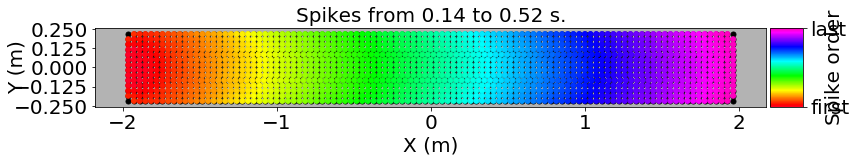

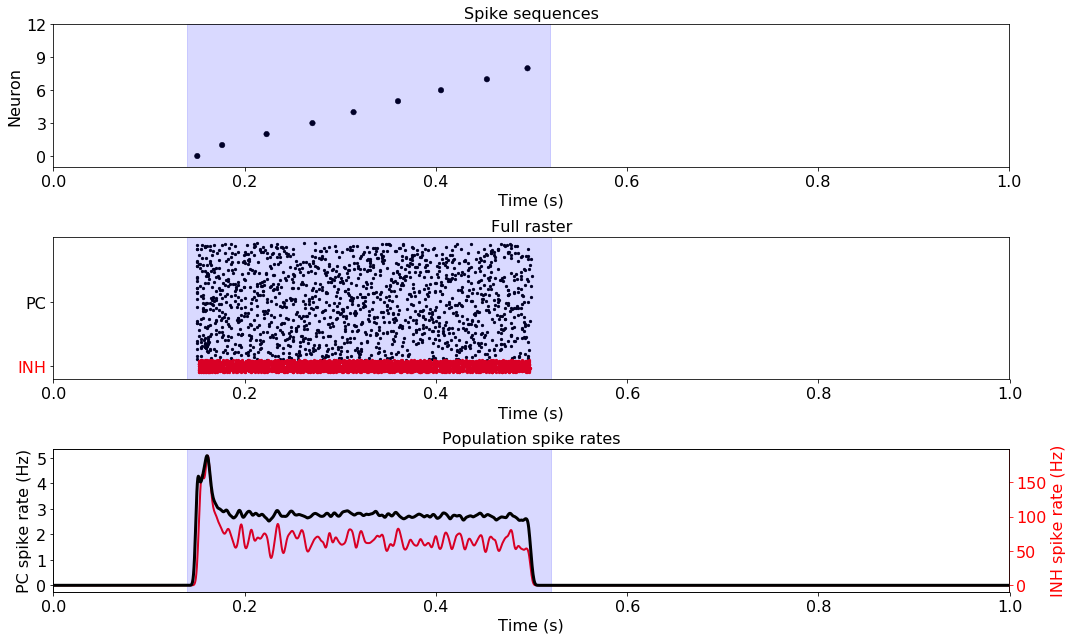

In [5]:
# run smln
m_params = copy(M_PARAMS)
s_params = copy(S_PARAMS)

s_params['RNG_SEED'] = 0

print('Running smln...')
rslt = smln_run(m_params, s_params)
print('Smln complete.')

# make plots
XYS_RASTER = [
    (-2, 0), (-1.5, 0), (-1, 0), (-.5, 0), (0, 0), (.5, 0), (1, 0), (1.5, 0), (2, 0)
]
EPOCHS = [(.14, .52)]

## selected replay epoch spike sequences
for epoch in EPOCHS:
    fig, ax = plot_spike_seq(rslt, epoch=epoch)

## raster for selected PCs
fig, axs = plot_raster_with_pc_inh(
    rslt,
    XYS_RASTER,
    colors=np.zeros(len(XYS_RASTER)),
    cmap='inferno',
    nearest=1,
    epoch=(0, 1),
    trg_plt=[],
    y_lim=(-1, 9),
    y_ticks=[0, 3, 6, 9, 12],
    smoothness=4)

## shade selected replay epochs
for epoch in EPOCHS:
    axs[0].axvspan(*epoch, color='b', alpha=0.15)
    axs[1].axvspan(*epoch, color='b', alpha=0.15)
    axs[2].axvspan(*epoch, color='b', alpha=0.15)